bootstrapping & .632 selection, part 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import scipy.stats

In [4]:
plt.style.use('dark_background')

In [5]:
1 - (1/np.exp(1))

np.float64(0.6321205588285577)

In [6]:
(99/100)**100

0.3660323412732292

In [7]:
rng = np.random.default_rng(2720)

In [8]:
len(rng.choice(10,10))

10

In [9]:
len(set(rng.choice(100,100)))

61

more fun with the differences between approximation and reality...

say you have a set of values {1...n} and you sample from it with replacement `n` times. how many distinct values will you get, on average? It's very likely to select one that has already been selected before, so it won't be 100%. 

Say it's 100 pieces of paper in a bag. The first 10 draws, it's unlikely to re-draw one we've seen before. At the end of the process, it's much more likely. Let's say we've made 90 draws and so far have gotten 60 unique values from the bag. For draw #91, there are 60 items we've already drawn, and 40 that we haven't. So there's a 60% chance of getting a repeat. If we've gotten 70 unique items out of 90, there's an even bigger chance of getting a repeat. It's kind of self correcting in a way that's worth thinking about for a second. The more unique items so far, the more likely the next item selected will be one we've seen before.

The math here is not too bad. Pick your favorite number between 1 and 100. The chance it is drawn is 1/100. So the chance it isn't drawn is 99/100.

Each draw is independent, so we can multiply probabilities together.  For 100 draws, that's equal to:

In [10]:
p_not_chosen = (99/100) ** 100

p_not_chosen

0.3660323412732292

Every number is either chosen, or not chosen. So the probability our number was chosen is:

In [11]:
1 - p_not_chosen

0.6339676587267709

In [12]:
1 - (99/100) ** 1

0.010000000000000009

In [13]:
x = np.arange(0,100)
y = 1-  ((99/100) ** x)

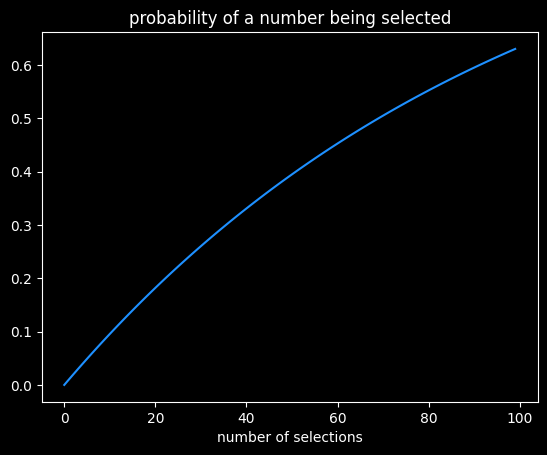

In [14]:
plt.plot(x,y, color='dodgerblue')
_ = plt.title("probability of a number being selected")
_ = plt.xlabel("number of selections")

If we generalize the process above, something cool happens. `n` is the number of elements we're choosing from. As n gets big, the probability of a number not being chosen is:

$\lim\limits_{n\to\infty}(\frac{n-1}{n})^{n}$

It turns out this is equal to $\frac{1}{e}$ ! Yeah, e! Your old buddy from calculus class. You know, the $e^{i\pi}$ guy?

See the proof at the end, included mainly as LaTex practice for me.

$\frac{1}{e}$ pops up in a bunch of places


In [15]:
1/np.e

0.36787944117144233

The probability of a number not being chosen is the same as the probability of it being chosen exactly once, which might be a little surprising.  


     
That means the probability of an item being chosen more than once is $1 - \frac{2}{e}$ -- that's over 26%. Doesn't that seem kind of high?

In [16]:
1 - (2/np.exp(1))

np.float64(0.26424111765711533)

as always, I like to simulate stuff 

In [17]:
multi_counts = []

length_counts = []

worst_case = 0
worst_data = None

for x in range(100000):
    sample = pd.Series(rng.choice(100,100))
    ### find total number selected
    length_counts.append(len(set(sample)))

    ### find ones selected >1 time
    vc = sample.value_counts()
    multi_selections = len(vc[vc.values>1])
    multi_counts.append(multi_selections)

    if multi_selections > worst_case:
        worst_case = multi_selections
        worst_data = sample

multi_counts = pd.Series(multi_counts)

In [18]:
min(length_counts)

49

In [19]:
max(length_counts)

76

considering I did 100,000 simulations, a range of 50-75 values is a pretty tight spread.

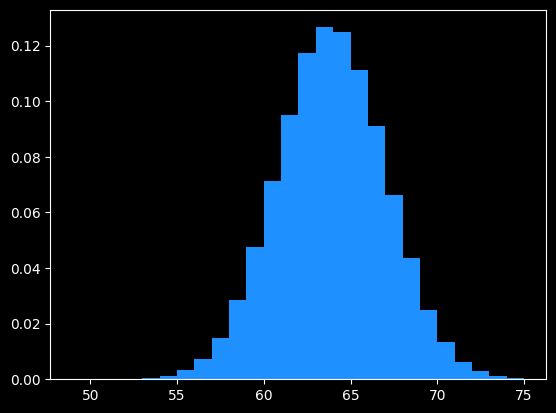

In [20]:

_hists = plt.hist(length_counts, bins=range(min(length_counts), max(length_counts)), 
                  density=True, color='dodgerblue')

comparing this to 100 trials of a binomial distribution w/ a 63.4% success rate

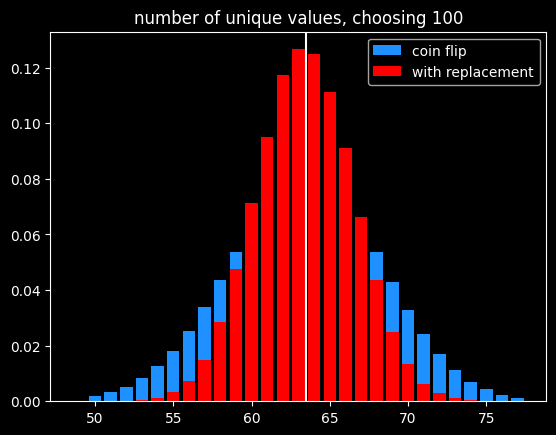

In [21]:
bino = scipy.stats.binom(100, .634)

bino_df = pd.DataFrame({
    'x': [x for x in range(50,78)],
    'y': [bino.pmf(x) for x in range(50,78)]

})

plt.bar(bino_df.x, bino_df.y, label="coin flip", color="dodgerblue")

plt.bar(_hists[1][:-1], _hists[0], color="red", label="with replacement")

plt.title("number of unique values, choosing 100")

plt.axvline(63.5, color="white")

_ = plt.legend()

In [22]:
series_lc = pd.Series(length_counts)

In [23]:
series_lc.describe()

count    100000.000000
mean         63.396840
std           3.102321
min          49.000000
25%          61.000000
50%          63.000000
75%          65.000000
max          76.000000
dtype: float64

In [24]:
np.percentile(series_lc, 5)

np.float64(58.0)

In [25]:
np.percentile(series_lc, 95)

np.float64(68.0)

equivalent binomial:


In [26]:
np.sqrt(100 * .6338 * (1-.6338))

np.float64(4.817650464697496)

In [27]:
4.818/3.119

1.5447258736774605

equivalent poisson (doesn't really make sense)


In [28]:
np.sqrt(63.36) / 3.119

np.float64(2.5520678091865854)

### distribution of multiple counts

the number of items that was selected 2+ times has an even tighter distribution

In [29]:
multi_counts.describe()

count    100000.000000
mean         26.417290
std           2.428312
min          17.000000
25%          25.000000
50%          26.000000
75%          28.000000
max          36.000000
dtype: float64

In [30]:
max(multi_counts)

36

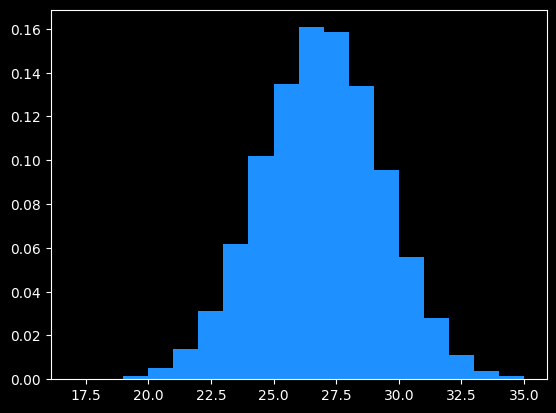

In [31]:

_hists = plt.hist(multi_counts, bins=range(min(multi_counts), max(multi_counts)), 
                  density=True, color='dodgerblue')

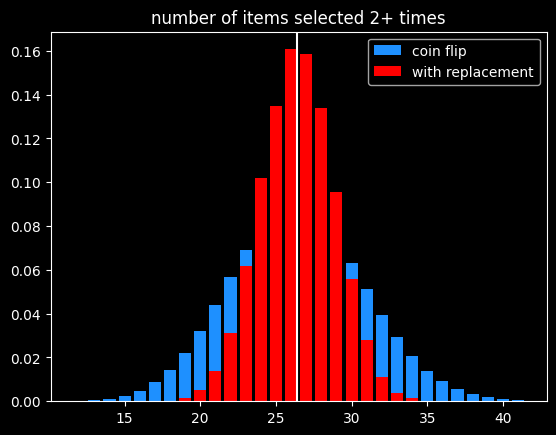

In [32]:

bino = scipy.stats.binom(100, (1-2/np.e))

bino_df = pd.DataFrame({
    'x': [x for x in range(12,42)],
    'y': [bino.pmf(x) for x in range(12,42)]

})


plt.bar(bino_df.x, bino_df.y, label="coin flip", color="dodgerblue")
plt.bar(_hists[1][:-1], _hists[0], color="red", label="with replacement")


plt.title("number of items selected 2+ times")

plt.axvline(26.4, color="white")

_ = plt.legend()

In [33]:
2/np.e

0.7357588823428847

In [34]:
sum(bino_df.y)

0.999347551045417

In [35]:
np.sqrt(100 * .264 * (1-.264))

np.float64(4.407992740465891)

the equivalent binomal is almost 2x the standard deviation

In [36]:
4.4/2.43

1.8106995884773662

In [37]:
multi_counts

0        27
1        26
2        25
3        26
4        28
         ..
99995    24
99996    28
99997    25
99998    29
99999    28
Length: 100000, dtype: int64

### DERANGEMENTS

this will have to wait till next time.

In [38]:
rng.permutation(10)

array([7, 2, 8, 0, 4, 5, 3, 6, 9, 1])

In [39]:
def num_fixed_points(num):
    perm = rng.permutation(num)
    base = np.arange(num)
    return sum(perm == base)

In [40]:
fixed_point_counts = []

NUM_ITERS = 1000000

for x in range(NUM_ITERS):
    fixed_point_counts.append(num_fixed_points(10))



In [41]:
fpc = pd.Series(fixed_point_counts)
fpc.value_counts()

1    368315
0    367716
2    183908
3     61025
4     15338
5      3078
6       535
7        72
8        13
Name: count, dtype: int64

In [42]:
fpc.describe()

count    1000000.000000
mean           0.999766
std            0.999809
min            0.000000
25%            0.000000
50%            1.000000
75%            2.000000
max            8.000000
dtype: float64

In [43]:
gvc = fpc.value_counts()

In [44]:
gvc.index * gvc.values

Index([368315, 0, 367816, 183075, 61352, 15390, 3210, 504, 104], dtype='int64')

expected value should be 1. distribution should be a poisson with mean = 1 (and thus variance = 1)


In [45]:
fpc.describe()

count    1000000.000000
mean           0.999766
std            0.999809
min            0.000000
25%            0.000000
50%            1.000000
75%            2.000000
max            8.000000
dtype: float64

<BarContainer object of 9 artists>

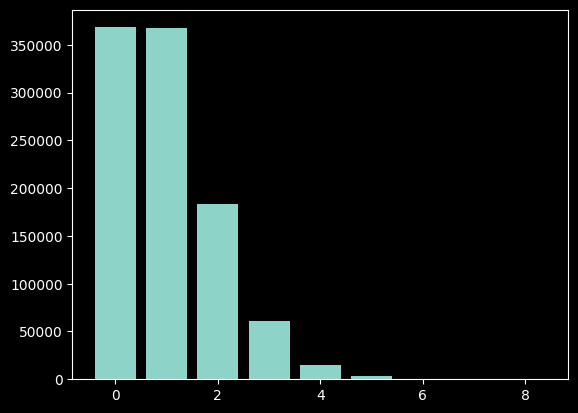

In [46]:
plt.bar(range(0,9),fpc.value_counts().values)

## HERE BE DRAGONS

stuff after this point is junky/leftover stuff


what about small sample size?

In [47]:
## this will simulate .632 selection

distinct_counts = []

for x in range(1000000):
    indices = rng.choice(10,10)
    distinct = len(set(indices)) # this eliminates duplicates
    distinct_counts.append(distinct)

boo =pd.Series(distinct_counts)



In [48]:
1 - (1-1/10)**10

0.6513215599

<Axes: >

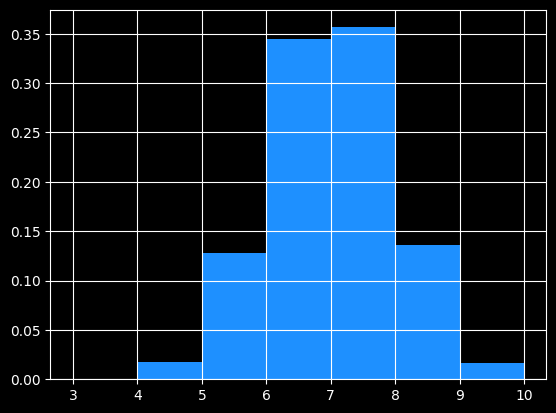

In [49]:
boo.hist(bins=range(3,11), color='dodgerblue', density=True)

In [50]:
(99/100)**100

0.3660323412732292

In [51]:
boo.describe()

count    1000000.000000
mean           6.513265
std            0.995393
min            2.000000
25%            6.000000
50%            7.000000
75%            7.000000
max           10.000000
dtype: float64

### is there a performance difference between replacement and non-replacement?



In [64]:

def bootstrap_performance(n_items):
    """
    do a classic bootstrap to select ~ 63.2% of items
    """
    choices = set(rng.choice(n_items, n_items, replace=True))
    return choices


def without_replacement_performance(n_items):
    choices = set(rng.choice(n_items, round(.632 * n_items), replace=False))
    return choices


In [61]:
len(without_replacement_performance(100))

63

In [62]:
import timeit

In [73]:
t1 = timeit.timeit("bootstrap_performance(100)", number=10000, setup="from __main__ import bootstrap_performance")
t2 = timeit.timeit("without_replacement_performance(100)", number=10000, setup="from __main__ import without_replacement_performance")

print(t1)
print(t2)
print(t1/t2)

0.1555434000911191
0.1139050000347197
1.3655537513165137


0.013663099962286651

## references/etc

https://oeis.org/A068985